In [1]:
import numpy as np
import pandas as pd
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import Sequence
from keras.layers import *
import matplotlib.pyplot as plt
import optuna

In [2]:
#import split data lol 
X_set1 = np.array(np.load('X_set1.npy', allow_pickle = True))
Y_set1 = np.array(np.load('Y_set1.npy', allow_pickle = True))
X_set2 = np.array(np.load('X_set2.npy', allow_pickle = True))
Y_set2 = np.array(np.load('Y_set2.npy', allow_pickle = True))

X_1 = np.concatenate((X_set1[0],X_set2[0]))
X_2 = np.concatenate((X_set1[1],X_set2[1]))
X_3 = np.concatenate((X_set1[2],X_set2[2]))

Y_1 = np.concatenate((Y_set1[0],Y_set2[0]))
Y_2 = np.concatenate((Y_set1[1],Y_set2[1]))
Y_3 = np.concatenate((Y_set1[2],Y_set2[2]))

#X = np.array([X_1,X_2,X_3])
#Y = np.array([Y_1,Y_2,Y_3])

X_train, X_test, X_val = X_set1 
Y_train, Y_test, Y_val = Y_set1 


X_train = np.asarray(X_train).astype('float32')
Y_train = np.asarray(Y_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
Y_val = np.asarray(Y_val).astype('float32')
X_test = np.asarray(X_test).astype('float32')
Y_test = np.asarray(Y_test).astype('float32')
X_train = X_train.reshape(len(X_train), 250, 1)
X_val = X_val.reshape(len(X_val), 250, 1)
X_test = X_test.reshape(len(X_test), 250, 1)
print(X_train.shape)

(10199, 250, 1)


In [6]:
def randomplot(X_train,Y_train, X_test, Y_test, model):
    rand_inst = np.random.randint(0,X_test.shape[0]-1)
    Y_predict = model.predict(X_test[rand_inst:rand_inst+1])
    print(rand_inst)
    print('Values in the Order of: cw1, cw2, eqw1, eqw2')
    print('Actual Values of Test Set: '+str(Y_test[rand_inst]))
    print('Predicted Values of Test Set: '+str(Y_predict[0]))
    percent_err_cw1 = 100*abs(Y_predict[0][0] - Y_test[rand_inst][0])/Y_test[rand_inst][0]
    percent_err_cw2 = 100*abs(Y_predict[0][1] - Y_test[rand_inst][1])/Y_test[rand_inst][1]
    percent_err_eqw1 = 100*abs(Y_predict[0][2] - Y_test[rand_inst][2])/Y_test[rand_inst][2]
    percent_err_eqw2 = 100*abs(Y_predict[0][3] - Y_test[rand_inst][3])/Y_test[rand_inst][3]
    print('Individual Percent Errors: ')
    print(percent_err_cw1, percent_err_cw2, percent_err_eqw1, percent_err_eqw2)
    actual_distance = abs(Y_test[rand_inst][0] - Y_test[rand_inst][1])
    predict_distance = abs(Y_predict[0][0] - Y_predict[0][1])
    actual_eqwdiff = abs(Y_test[rand_inst][2] - Y_test[rand_inst][3])
    predict_eqwdiff = abs(Y_predict[0][2] - Y_predict[0][3])
    #print('Actual Distance between CWs: '+str(actual_distance))
    #print('Predicted Distance between CWs: '+str(predict_distance))
    percent_err_dist = 100*abs(predict_distance - actual_distance)/actual_distance
    print('CW Distance Percent Error: '+str(percent_err_dist))
    #print('Actual Difference between EQWs: '+str(actual_eqwdiff))
    #print('Predicted Difference between EQWs: '+str(predict_eqwdiff))
    percent_err_eqwdiff = 100*abs(predict_eqwdiff - actual_eqwdiff)/actual_eqwdiff
    print('EQW Difference Percent Error: '+str(percent_err_eqwdiff))
    plt.plot(np.linspace(0,1,num=250),X_test[rand_inst])
    plt.vlines(Y_test[rand_inst][0:2], ymin=0.85, ymax=1, color = 'k', label = 'real')
    plt.vlines(Y_predict[0][0:2], ymin=0.85, ymax=1, color='r', label = 'predicted')
    plt.ylim([0.85,1.01])
    plt.ylabel('Normalized Flux')
    plt.xlabel('Normalized Wavelength')
    plt.legend()
    #plt.savefig('pptplot_blend2.png', dpi=300, bbox_inches='tight')

In [3]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    verbose=1,
    min_lr=1e-4
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience = 10, 
    restore_best_weights=True)

callbacks_list = [reduce_lr, early_stopping]

In [4]:
BATCH_SIZE = 10
input_shape = (250,1)

model= Sequential()
model.add(Conv1D(filters = 12, kernel_size = 12, strides = 2, activation='relu', padding = 'same', input_shape=(250,1)))#batch_size, amount of vectors in a single input, length of input
model.add(Conv1D(filters = 18, kernel_size = 14, strides = 2, activation='relu', padding = 'same'))
model.add(MaxPooling1D(2, padding = 'same'))
model.add(Conv1D(filters = 26, kernel_size = 10, strides = 2, activation='relu', padding = 'same'))
model.add(Conv1D(filters = 32, kernel_size = 8, strides = 2, activation='relu', padding = 'same'))
model.add(MaxPooling1D(2, padding = 'same'))
model.add(Conv1D(filters = 48, kernel_size = 6, strides = 2, activation='relu', padding = 'same'))
model.add(Conv1D(filters = 54, kernel_size = 4, strides = 2, activation='relu', padding = 'same'))
model.add(MaxPooling1D(2, padding = 'same'))
model.add(Conv1D(filters = 80, kernel_size = 3, strides = 2, activation='relu', padding = 'same'))
model.add(Conv1D(filters = 86, kernel_size = 3, strides = 2, activation='relu', padding = 'same'))
model.add(MaxPooling1D(2, padding = 'same'))
model.add(Conv1D(filters = 130, kernel_size = 2, strides = 2, activation='relu', padding = 'same'))
model.add(Conv1D(filters = 136, kernel_size = 2, strides = 2, activation='relu', padding = 'same'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(4, activation='relu'))
model.summary()
model.compile(loss='MSE',optimizer='adam')
history = model.fit(X_train,Y_train, validation_data = (X_val,Y_val), batch_size = BATCH_SIZE, epochs = 500, verbose=1,callbacks=callbacks_list )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 125, 12)           156       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 63, 18)            3042      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 18)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 26)            4706      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 32)             6688      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 32)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 48)             9

1020/1020 [==============================] - 12s 12ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 52/500
1020/1020 [==============================] - 12s 12ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 53/500
1020/1020 [==============================] - 12s 12ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 54/500
1020/1020 [==============================] - 13s 13ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 55/500
1020/1020 [==============================] - 12s 12ms/step - loss: 0.0054 - val_loss: 0.0055


2705
Values in the Order of: cw1, cw2, eqw1, eqw2
Actual Values of Test Set: [0.6788     0.744      0.3386162  0.01195739]
Predicted Values of Test Set: [0.6398457  0.78318214 0.29325002 0.        ]
Individual Percent Errors: 
5.738694566932909 5.266414730230105 13.397518798064509 100.0
CW Distance Percent Error: 119.8410238829848
EQW Difference Percent Error: 10.227426684296685


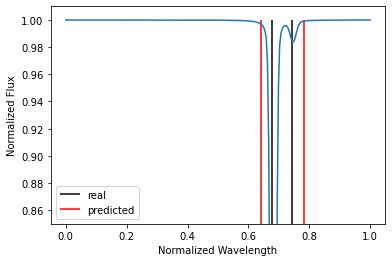

In [19]:
randomplot(X_train,Y_train,X_test,Y_test,model)